# **Two fold cross validation for linear regression, neural network and baseline**

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, precision_score
import pandas as pd

## Load dataset

In [2]:
filename = 'heart_failure_clinical_records_dataset.csv'
df = pd.read_csv(filename)
y = df['age']
X = df.drop(['age'], axis = 1)
attributeNames = list(X.keys())
X = X.to_numpy()
y = y.to_numpy()

mu = np.mean(X, 0)
sigma = np.std(X, 0)
X = (X - mu) / sigma
classNames = "DEATH_EVENT"
N, M = X.shape
C = 2

## Define our models

We are going to define two models:

- A baseline model
- A Linear regression model
- A neural network

### Baseline

In [3]:
# We compute and return the mean of our train_dataset
def baseline(y_par, y_test):
    dataset_index = y_test.index
    dataset = y_par.to_numpy()
    mean = np.mean(dataset)
    baseline = pd.Series(np.full((300), mean))
    baseline = baseline.iloc[dataset_index]
    return baseline


### Linear regression

In [4]:

log_reg = lambda regularization: Ridge(regularization, copy_X= True, max_iter= 2500)

### ANN

In [5]:
nn = lambda n_hidden_units: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to H hiden units
                    torch.nn.Tanh(),   # 1st transfer function,
                    torch.nn.Linear(n_hidden_units, 1), # H hidden units to 1 output neuron
                    )
loss_fn = torch.nn.MSELoss()

In [6]:
# From course Introduction to Machine learning and data mining toolbox
def train_neural_net(model, loss_fn, X, y, n_hidden_units,
                     n_replicates=1, max_iter = 10000, tolerance=1e-6):
    # Specify maximum number of iterations for training
    logging_frequency = 1000 # display the loss every 1000th iteration
    best_final_loss = 1e100
    for r in range(n_replicates):
        # Make a new net (calling model() makes a new initialization of weights) 
        net = model(n_hidden_units)
        
        # initialize weights based on limits that scale with number of in- and
        # outputs to the layer, increasing the chance that we converge to 
        # a good solution
        torch.nn.init.xavier_uniform_(net[0].weight)
        torch.nn.init.xavier_uniform_(net[2].weight)
                     
        # We can optimize the weights by means of stochastic gradient descent
        # The learning rate, lr, can be adjusted if training doesn't perform as
        # intended try reducing the lr. If the learning curve hasn't converged
        # (i.e. "flattend out"), you can try try increasing the maximum number of
        # iterations, but also potentially increasing the learning rate:
        #optimizer = torch.optim.SGD(net.parameters(), lr = 5e-3)
        
        # A more complicated optimizer is the Adam-algortihm, which is an extension
        # of SGD to adaptively change the learing rate, which is widely used:
        optimizer = torch.optim.Adam(net.parameters())
        
        # Train the network while displaying and storing the loss
        learning_curve = [] # setup storage for loss at each step
        old_loss = 1e6
        for i in range(max_iter):
            y_est = net(X) # forward pass, predict labels on training set
            loss = loss_fn(y_est, y) # determine loss
            loss_value = loss.data.numpy() #get numpy array instead of tensor
            learning_curve.append(loss_value) # record loss for later display
            
            # Convergence check, see if the percentual loss decrease is within
            # tolerance:
            p_delta_loss = np.abs(loss_value-old_loss)/old_loss
            if p_delta_loss < tolerance: break
            old_loss = loss_value
            
            # display loss with some frequency:
            # do backpropagation of loss and optimize weights 
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            
            
        # display final loss
        
        if loss_value < best_final_loss: 
            best_net = net
            best_final_loss = loss_value
            best_learning_curve = learning_curve
            best_hidden_unit = n_hidden_units
        
    # Return the best curve along with its final loss and learing curve
    return best_net

## Two fold cross-validation

In [15]:

y.squeeze()

# Variables to control fold splits
K1 = 10
K2 = 10

# Initialize variables
lambda_interval = np.logspace(1, 3, 10) # Holds regularization values for our logistic regression model
hidden_units_interval = [6, 7, 8, 9, 10] # Holds hidden units range for our neural network
final_models_lambda = []
final_models_reg_error = []
final_models_hidden_unit = []
final_models_nn_error = []
final_baseline_error = []
Baseline_pred = []
Regression_pred = []
Network_pred = []
Y_true = []
Error_test = np.empty((K1,1))
Validation_error_nn = np.zeros((len(hidden_units_interval), K2))
Validation_error_reg = np.zeros((len(lambda_interval), K2)) 

Outer_fold = KFold(n_splits = K1, shuffle = True)
Inner_fold =  KFold(n_splits = K2, shuffle = True)

for i, (par_index, test_index) in enumerate(Outer_fold.split(X,y)):
    print('\nCrossvalidation outer fold: {0}/{1}'.format(i+1,K1))
    X_par, y_par = X[par_index,:], y[par_index]
    X_test, y_test = X[test_index,:], y[test_index]

    Generalization_error_reg = []
    Generalization_error_nn = []
    Generalization_error_base = []
    Y_true.append(y_test)

    for j, (train_index, val_index) in enumerate(Inner_fold.split(X_par, y_par)):
        print('\nCrossvalidation inner fold: {0}/{1}'.format(j+1,K2))
        X_train, y_train = X_par[train_index, :], y_par[train_index]
        X_val, y_val = X_par[val_index], y_par[val_index]

        # Now we test our s models in regression
        for s, lambda_val in enumerate(lambda_interval):
            model  = log_reg(lambda_val)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            Validation_error_reg[s,j] = (len(y_val)/len(y_par))*(np.square(y_pred - y_val).sum(axis = 0))/len(y_pred)
        
        X_train_t = torch.tensor(X_train, dtype= torch.float)
        y_train_t = torch.tensor(y_train, dtype= torch.float)
        X_val_t = torch.tensor(X_val, dtype= torch.float)
        y_val_t = torch.tensor(y_val, dtype= torch.float)
        # Test for each hidden unit
        for h, n_hidden_units in enumerate(hidden_units_interval):
            net = train_neural_net(nn, loss_fn, X_train_t, y_train_t, n_hidden_units)
            y_test_est = net(X_val_t)
            y_test_est = y_test_est.detach().numpy()
            y_test_est = y_test_est.reshape(y_val.shape)
            # Determine errors and errors
            Validation_error_nn[h,j] = (len(y_val)/len(y_par))*(np.square(y_test_est - y_val).sum(axis = 0))/len(y_test_est)
            
    
    # We compute for each model its generalization error
    for s in range(len(lambda_interval)):
        Generalization_error_reg.append(np.sum(Validation_error_reg[s, :]))

    for h in range(len(hidden_units_interval)):
        Generalization_error_nn.append(np.sum(Validation_error_nn[h, :]))

    # We select the best model and compute its test error with D_test
    min_index_reg = np.argmin(Generalization_error_reg)
    best_lambda = lambda_interval[min_index_reg]
    model = log_reg(best_lambda)
    model.fit(X_par, y_par)
    y_pred = model.predict(X_test)
    error_test_reg = np.square(y_pred - y_test).sum(axis = 0)/len(y_pred)
    Regression_pred.append(y_pred)

    X_par_t = torch.tensor(X_par, dtype= torch.float)
    y_par_t = torch.tensor(y_par, dtype= torch.float)
    X_test_t = torch.tensor(X_test, dtype= torch.float)
    y_test_t = torch.tensor(y_test, dtype= torch.float)

    min_index_nn = np.argmin(Generalization_error_nn)
    best_hidden_unit = hidden_units_interval[min_index_nn]
    net = train_neural_net(nn, loss_fn, X_par_t, y_par_t, best_hidden_unit)
    y_test_est = net(X_test_t)
    y_test_est = y_test_est.detach().numpy()
    y_test_est = y_test_est.reshape(y_test.shape)
    error_test_nn = np.square(y_test_est - y_test).sum(axis = 0)/len(y_test)
    Network_pred.append(y_test_est)

    y_pred_baseline = baseline(pd.Series(y_par), pd.Series(y_test))
    
    final_baseline_error.append(np.square(y_pred_baseline - y_test).sum(axis = 0)/len(y_pred_baseline))
    Baseline_pred.append(y_pred_baseline)
    
    # We store the final models data
    final_models_lambda.append(best_lambda)
    final_models_reg_error.append(error_test_reg)
    final_models_hidden_unit.append(best_hidden_unit)
    final_models_nn_error.append(error_test_nn)

        



Crossvalidation outer fold: 1/10

Crossvalidation inner fold: 1/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 2/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 3/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 4/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 5/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 6/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 7/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 8/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 9/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 10/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([269])) that is different to the input size (torch.Size([269, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation outer fold: 2/10

Crossvalidation inner fold: 1/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 2/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 3/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 4/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 5/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 6/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 7/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 8/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 9/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 10/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([269])) that is different to the input size (torch.Size([269, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation outer fold: 3/10

Crossvalidation inner fold: 1/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 2/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 3/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 4/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 5/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 6/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 7/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 8/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 9/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 10/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([269])) that is different to the input size (torch.Size([269, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation outer fold: 4/10

Crossvalidation inner fold: 1/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 2/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 3/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 4/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 5/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 6/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 7/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 8/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 9/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 10/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([269])) that is different to the input size (torch.Size([269, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation outer fold: 5/10

Crossvalidation inner fold: 1/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 2/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 3/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 4/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 5/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 6/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 7/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 8/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 9/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 10/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([269])) that is different to the input size (torch.Size([269, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation outer fold: 6/10

Crossvalidation inner fold: 1/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 2/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 3/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 4/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 5/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 6/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 7/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 8/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 9/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 10/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([269])) that is different to the input size (torch.Size([269, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation outer fold: 7/10

Crossvalidation inner fold: 1/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 2/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 3/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 4/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 5/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 6/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 7/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 8/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 9/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 10/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([269])) that is different to the input size (torch.Size([269, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation outer fold: 8/10

Crossvalidation inner fold: 1/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 2/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 3/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 4/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 5/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 6/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 7/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 8/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 9/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 10/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([269])) that is different to the input size (torch.Size([269, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation outer fold: 9/10

Crossvalidation inner fold: 1/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 2/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 3/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 4/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 5/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 6/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 7/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 8/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 9/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 10/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([269])) that is different to the input size (torch.Size([269, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation outer fold: 10/10

Crossvalidation inner fold: 1/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 2/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 3/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 4/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 5/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 6/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 7/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 8/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 9/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Crossvalidation inner fold: 10/10


/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/erik/anaconda3/envs/ann/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([270])) that is different to the input size (torch.Size([270, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [26]:
data = {"Outer fold": range(1, K1 + 1),
        "h": final_models_hidden_unit,
        "ANN": final_models_nn_error,
        "lambda": final_models_lambda,
        "Logistic regression": final_models_reg_error,
        "Baseline": final_baseline_error}

df = pd.DataFrame(data)
df.set_index("Outer fold")

print(df)

   Outer fold   h         ANN      lambda  Logistic regression    Baseline
0           1   9  165.844257  359.381366           153.508819  165.710822
1           2   8  101.526174  215.443469           100.697471  101.627165
2           3   9  109.927169  359.381366           104.960100  110.155583
3           4   8  145.954405  359.381366           137.880123  145.461722
4           5   9  207.366316  359.381366           197.180958  206.955365
5           6   9  148.286328  599.484250           138.882340  148.877279
6           7   8  177.251710  599.484250           168.365178  175.532578
7           8  10  141.382636  359.381366           125.268455  140.972992
8           9   8  137.925846  599.484250           126.282913  140.171460
9          10   8   80.673707  359.381366            70.877802   81.710626


In [9]:
import scipy.stats as st

Baseline_pred = np.concatenate(Baseline_pred)
Regression_pred = np.concatenate(Regression_pred)
Network_pred =  np.concatenate(Network_pred)
Y_true = np.concatenate(Y_true)

zBaseline = np.abs(Y_true - Baseline_pred ) ** 2
zRegression = np.abs(Y_true - Regression_pred ) ** 2
zNetwork = np.abs(Y_true - Network_pred ) ** 2
alpha = 0.05

# Compare Baseline and Regression
z = zBaseline - zRegression
CI = st.t.interval(1-alpha, len(z)-1, loc=np.mean(z), scale=st.sem(z))  # Confidence interval
p = 2*st.t.cdf( -np.abs( np.mean(z) )/st.sem(z), df=len(z)-1)  # p-value
print("z = zBaseline - zRegression point estimate", " CI: ", CI, "p-value", p)

# Compare Baseline and Network
z = zBaseline - zNetwork
CI = st.t.interval(1-alpha, len(z)-1, loc=np.mean(z), scale=st.sem(z))  # Confidence interval
p = 2*st.t.cdf( -np.abs( np.mean(z) )/st.sem(z), df=len(z)-1)  # p-value
print("z = zBaseline - zNetwork point estimate", " CI: ", CI, "p-value", p)

# Compare Network and Regression
z = zRegression - zNetwork
CI = st.t.interval(1-alpha, len(z)-1, loc=np.mean(z), scale=st.sem(z))  # Confidence interval
p = 2*st.t.cdf( -np.abs( np.mean(z) )/st.sem(z), df=len(z)-1)  # p-value
print("z = zRegression - zNetwork point estimate", " CI: ", CI, "p-value", p)

z = zBaseline - zRegression point estimate  CI:  (-5.032541586286708, 14.779795547021191) p-value 0.3337329634406434
z = zBaseline - zNetwork point estimate  CI:  (-2.3090596088794912, 1.3918599644661722) p-value 0.6261074687694497
z = zRegression - zNetwork point estimate  CI:  (-15.892089354028679, 5.227635748880873) p-value 0.32116337856029914


Text(0, 0.5, 'E test')

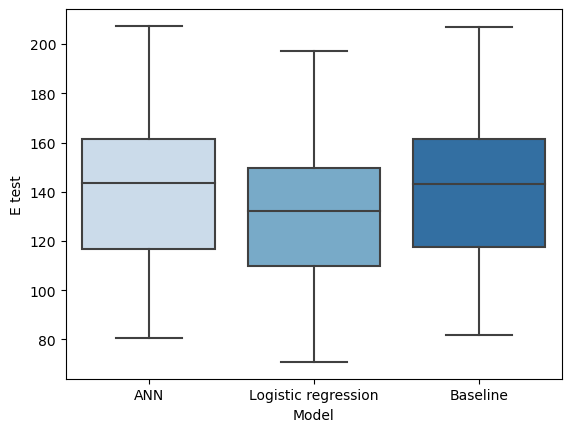

In [34]:
import seaborn as sn

#df = df.drop(["lambda", "h", "Outer fold"], axis = 1)
sn.boxplot(data= df, palette="Blues")
plt.xlabel('Model')
plt.ylabel('E test')